# Capstone Project: Recipe Analysis and Classification for Meal Kit Services

# Part 4: Data Modeling

For this section, I will train several models to predict the cuisine of a recipe based on its ingredients.
I will use my final model to answer the following questions:
1. Can we classify recipe cuisines based on only the listed ingredients?
2. Which cuisines share similar ingredient profiles?
3. What are the most distinctive ingredients in a cuisine?

### Contents:
1. [Model Preprocessing](#1.-Model-Preprocessing)
2. [Baseline Model](#2.-Baseline-Model)
3. [Multinomial Naive Bayes](#3.-Multinomial-Naive-Bayes)
4. [Logistic Regression](#4.-Logistic-Regression)
5. [Random Forest Classifier](#5.-Random-Forest-Classifier)
5. [Support Vector Classifier](#6.-Support-Vector-Classifier)
7. [Final Model Evaluation](#7.-Final-Model-Evaluation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import ast
import pickle
import itertools


from sklearn.metrics import classification_report, cohen_kappa_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, cross_validate, StratifiedKFold 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
plt.style.use('ggplot')

In [2]:
# import dataframe
data = pd.read_csv('../data/processed/cleaned_data.csv', sep=',', 
                   converters={'ingredients':ast.literal_eval,
                               'ingredientLines': ast.literal_eval})

In [3]:
# display first 5 rows
data.head()

,name,id,ingredientLines,rating,cuisine,source,flav_is_missing,Bitter,Meaty,Piquant,Salty,Sour,Sweet,totalTimeInMinutes,ingredients,number_of_ingredients
0,takeout style chinese spare ribs (take 2),takeout-style-chinese-spare-ribs-_take-2_-771701,"[5 cloves freshly minced garlic, 1 tablespoon ...",4,Chinese,http://thewoksoflife.com/2014/03/takeout-style...,0,5,4,1,5,3,5,450.0,"[hoisin sauce, water, spice, star anise, garli...",18
1,corned beef and vegetables,corned-beef-and-vegetables-1907240,"[1 whole corned beef brisket (6 to 8 pounds), ...",4,Irish,http://www.goingmywayz.com/corned-beef-vegetab...,0,1,1,3,1,5,1,135.0,"[water, carrot, beef brisket, coriander, parsn...",14
2,kung pao chicken,kung-pao-chicken-1096839,"[1 tablespoon soy sauce, 2 teaspoons Chinese r...",3,Chinese,http://www.epicurious.com/recipes/food/views/k...,0,1,1,5,1,1,1,40.0,"[ginger, chicken, sichuan pepper, black vinega...",19
3,"pulpo gallego, spanish octopus with paprika",pulpo-gallego_-spanish-octopus-with-paprika-21...,"[2 to 3 pounds octopus, 1 bunch of parsley, To...",4,Spanish,https://honest-food.net/pulpo-gallego-recipe-o...,0,5,2,3,1,5,1,110.0,"[cayenne, lemon, black pepper, garlic, paprika...",14
4,pork carnitas,pork-carnitas-590301,"[4 pound boneless pork butt, fat trimmed and c...",4,Mexican,http://www.mykitchenescapades.com/2012/11/pork...,0,2,4,0,4,3,1,165.0,"[water, lime, cumin, onion, pepper, oregano, o...",10


In [4]:
data.columns

Index(['name', 'id', 'ingredientLines', 'rating', 'cuisine', 'source',
       'flav_is_missing', 'Bitter', 'Meaty', 'Piquant', 'Salty', 'Sour',
       'Sweet', 'totalTimeInMinutes', 'ingredients', 'number_of_ingredients'],
      dtype='object')

## 1. Model Preprocessing

The classification models cannot directly process the list of ingredients as most of them expect numerical feature vectors with a fixed size instead of a list of strings of variable length. In order to extract usable features from the list of ingredients, I will use a bag of words model - for each document (i.e. the list of ingredients for a recipe), the frequency of words is taken into account, but the order in which they occur is ignored.
I will use the Term Frequency, Inverse Document Frequency (tf-idf) vectorizer to convert each document into a feature vector. 

TF-IDF evaluates how relevant a word is to a document in a corpus. This is done by multiplying two metrics: how many times the word appears in a document, and the inverse document frequency of the word across a set of documents. For the case of ingredients in a recipe, an ingredient would only appear once in a given document, however, the inverse document frequency would be important as ingredients that appear across all cuisines (such as oil and onions) should probably be given less predictive power than words that only show up in a few recipes.

I will use the following parameters for the TF-IDF vectorizer:
* max_df is set to 0.95: this means that ingredients appearing in more than 95% of the recipes will be excluded from my bag of words
* binary is set to True: all non-zero term counts are set to 1. This means that if an ingredient appears more than once in a recipe, only the first mention of the ingredient will be included in my bag of words

In [5]:
# combine ingredients to single string instead of list
X_join = data['ingredients'].apply(lambda x: ' '.join(x).lower())

#tf-idf
tvec = TfidfVectorizer(binary=True, max_df = .95)
X = tvec.fit_transform(X_join.tolist())

In [6]:
y = data['cuisine']
labels = list(data['cuisine'].unique())

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)

I will train and fit my data on the following models:
1. Multinomial Naive Bayes
2. Logistic Regression
3. Random Forest Classifier
4. Linear Support Vector Machine

For each model, I will use stratified k-fold cross-validation to evaluate and further tune my models if there is evidence of overfitting. I will use a 5 cross fold strategy and evaluate the performance on the following metrics:
1. Precision (weighted): The proportion of predicted positives that are actually positive
2. Recall (weighted): The proportion of true positives that are correctly classified
3. F1-score (weighted): The harmonic mean of precision and recall. This is useful for cuisine classification because I would want to minimize the false positives and false negatives equally
4. Cohen's Kappa Score: A measure for accuracy that integrates measurements of chance and class imbalance. 

Unlike the macro scores (which is the simple arithmetic mean of all metrics across classes), the weighted scores will weight the average of the metric by the number of samples for each class. I will use the weighted scores instead of the macro scores for precision, recall, and F1-score to account for any class imbalance between cuisines.

I will be using Cohen's Kappa score as it is a more robust metric than accuracy. Accuracy can be misleading because it does not take into account class imbalance (therefore you can get a high accuracy score if you predict the majority label for all data points in an imbalanced data set). The kappa score is adjusted to account for the probability that a predicted label and true label are the same due to chance. The formula for this is shown below, where P_0 is the accuracy, and P_e is the probability that predicted and true labels are the same due to chance. More information on Cohen's Kappa score can be found [here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd): 
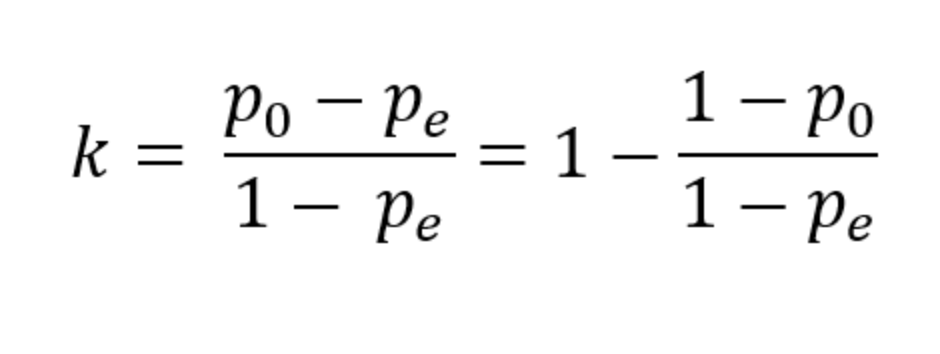

For each of the 4 models, I will use the classification report from sk-learn to see how well my model performs on testing data. The classification report will allow me to compare the precision, recall, and f1-score for each cuisine specifically, and provide an indication of which cuisines are more difficult to classify.

I will store the weighted precision, weighted recall, weighted F1-score, and Kappa score for each model so I can compare the performance of each model on the test dataset before I select my final model for production. 

In [2]:
# functions for modeling

#instantiate stratified k fold
skf = StratifiedKFold(n_splits=5)

# dictionaries to store cross val and test scores for model comparison
cross_val_dic = {}
test_dic = {}


# scoring dictionary for cross validation
scoring = {'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1': make_scorer(f1_score, average='weighted'),
           'kappa_score':make_scorer(cohen_kappa_score),
           }


def cross_val_score(model, X, y, scoring=scoring, cv= skf):
    """
    Evaluates a given model/estimator using cross-validation
    and returns a dict containing the absolute vlues of the average (mean) scores
    for classification models.

    model: scikit-learn classification model
    X: features (no labels)
    y: labels
    scoring: a dictionary of scoring metrics
    cv: cross-validation strategy
    """
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(model, X, y, scoring=scoring, cv=skf, n_jobs=-1)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}


def add_cross_val_score(name, model, X_train, y_train):
    """
    Evaluates a given model/estimator using the cross_val_score function 
    and returns an updated dataframe including the given model's cross validation scores
    for comparison.

    name: model name for dataframe (string)
    model: scikit-learn classification model
    X_train: training data features (no labels)
    y_train: training data labels
    """
    
    # add cross validation scores for model to dictionary
    cross_val_dic[name] = cross_val_score(model, X_train, y_train)
    # return updated dataframe
    return pd.DataFrame(cross_val_dic)


def add_test_score(name, model, X_test, y_test):
    """
    Evaluates a given model/estimator's predicted labels on the following metrics:
    Precision (weighted), Recall (weighted), F1-score (weighted), and Cohen Kappa Score
    Returns an updated dataframe including the model's performance on test data for comparison.

    name: model name for dataframe (string)
    model: scikit-learn classification model
    X_test: test data features (no labels)
    y_test: test data labels
    """
    
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    score_dic = {}
    score_dic['F1 score'] = report['weighted avg']['f1-score']
    score_dic['Kappa score'] = cohen_kappa_score(y_test, y_pred)
    score_dic['Precision'] = report['weighted avg']['precision']
    score_dic['Recall'] = report['weighted avg']['recall']
    
    test_dic[name] = score_dic
    return pd.DataFrame(test_dic)

## 2.  Baseline Model

The baseline model is the simplest model I can use to predict the cuisine. For my baseline model, I will randomly predict a cuisine for my test dataset, and compare this to the actual cuisines. Since the actual cuisines for my test dataset should be unknown when I am making my predictions, I will assume the probability of predicting a cuisine is the same as the proportion of recipes in my train data set that belong to that cuisine class.


In [9]:
np.random.seed(23)
baseline_pred = np.random.choice(y_train.value_counts(normalize = True).index, 
                  p=y_train.value_counts(normalize = True).values, 
                 size = y_test.shape, replace = True)

report = classification_report(y_test, baseline_pred, output_dict=True)
score_dic = {}
score_dic['F1 score'] = report['weighted avg']['f1-score']
score_dic['Kappa score'] = cohen_kappa_score(y_test, baseline_pred)
score_dic['Precision'] = report['weighted avg']['precision']
score_dic['Recall'] = report['weighted avg']['recall']
test_dic['Baseline Model'] = score_dic

In [10]:
print(classification_report(y_test, baseline_pred, target_names=labels))

              precision    recall  f1-score   support

     Chinese       0.04      0.03      0.03       190
       Irish       0.04      0.05      0.04       196
     Spanish       0.03      0.03      0.03       135
     Mexican       0.08      0.07      0.07       171
   Hungarian       0.05      0.05      0.05       195
      German       0.09      0.09      0.09       195
     Italian       0.03      0.04      0.04       199
      Indian       0.06      0.06      0.06       149
    Moroccan       0.04      0.04      0.04       119
        Thai       0.08      0.09      0.08       197
      French       0.08      0.08      0.08       149
    Hawaiian       0.08      0.08      0.08       198
       Cuban       0.09      0.08      0.08       193
       Greek       0.04      0.05      0.04       196
     Swedish       0.10      0.09      0.09       197
    Japanese       0.04      0.04      0.04       197
     English       0.04      0.04      0.04       107
    American       0.08    

## 3. Multinomial Naive Bayes

Multinomial naive bayes is a classification modelling technique that will find the probabilities of classes assigned to texts by using the joint probabilities of words and classes. Naive bayes makes the assumption that every feature is independent. This is most likely untrue in the case of ingredients in a recipe, where the probability of using a particular ingredient probably does depend on the other ingredients used in a recipe (for example. the probability of using sugar affects the probability of using another sweetener). However, I will still test this model because naive bayes classification models tend to perform well on text data.

I will use gridsearch to find the optimal alpha hyperparameter, which is the smoothing parameter used to account for ingredients which many not be present in the train set.

In [11]:
kappa = make_scorer(cohen_kappa_score)
nb = MultinomialNB()
param_grid = {'alpha': [1, 1e-1, 1e-2, 1e-3]}
nb_gs = GridSearchCV(nb, param_grid, scoring=kappa)

In [12]:
nb_gs.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001]},
             scoring=make_scorer(cohen_kappa_score))

In [13]:
nb_best = nb_gs.best_estimator_

In [14]:
add_cross_val_score('Multinomial Naive Bayes', nb_best, X_train, y_train)

,Multinomial Naive Bayes
fit_time,0.06462
score_time,0.06442
test_f1,0.80662
test_kappa_score,0.79796
test_precision,0.80888
test_recall,0.80959


In [15]:
print(classification_report(y_test, nb_best.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

     Chinese       0.70      0.53      0.60       190
       Irish       0.82      0.88      0.85       196
     Spanish       0.80      0.71      0.75       135
     Mexican       0.60      0.54      0.57       171
   Hungarian       0.65      0.67      0.66       195
      German       0.74      0.78      0.76       195
     Italian       0.84      0.94      0.89       199
      Indian       0.81      0.78      0.79       149
    Moroccan       0.91      0.73      0.81       119
        Thai       0.93      0.95      0.94       197
      French       0.74      0.74      0.74       149
    Hawaiian       0.81      0.81      0.81       198
       Cuban       0.93      0.89      0.91       193
       Greek       0.84      0.86      0.85       196
     Swedish       0.87      0.92      0.89       197
    Japanese       0.76      0.87      0.81       197
     English       0.76      0.74      0.75       107
    American       0.90    

In [16]:
add_test_score('Multinomial Naive Bayes', nb_best, X_test, y_test)

,Baseline Model,Multinomial Naive Bayes
F1 score,0.061475,0.799826
Kappa score,0.004389,0.790728
Precision,0.061798,0.800899
Recall,0.061340,0.802768


In [19]:
# save model
# with open('../models/cuisine_prediction/naivebayes.pkl', 'wb') as file:   
#    pickle.dump(nb_best, file)

## 4. Logistic Regression

For multiclass logistic regression, there are two algorithms that sklearn offers - OVR or multinomial.

One vs Rest (OVR) involves training a single classifier per class, with the samples of that class as positive and all other samples as negative. For OVR, the assumption is that there are N independent classification problems, and therfore for each class we learn an independent logistic model.

The second algorithm is a multinomial logistic regression classifier. In this case, instead of classifying each class seperately, the classifier uses the softmax function to predict if a single data point falls in one of the N classes. 

I will use gridsearch to select the optimal algorithm, as well as tune the regularization hyperparameter C.

In [20]:
mc = ['ovr', 'multinomial']
c = [0.01, 0.1, 1, 10, 100]
param_grid = {'C': c, 'multi_class': mc}

lr = LogisticRegression(max_iter = 5000)
lr_gs = GridSearchCV(lr, param_grid, scoring = kappa)

In [21]:
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['ovr', 'multinomial']},
             scoring=make_scorer(cohen_kappa_score))

In [22]:
lr_best = lr_gs.best_estimator_

In [23]:
lr_best

LogisticRegression(C=10, max_iter=5000, multi_class='multinomial')

In [24]:
add_cross_val_score('Logistic Regression', lr_best, X_train, y_train)

,Multinomial Naive Bayes,Logistic Regression
fit_time,0.06462,4.12098
score_time,0.06442,0.08895
test_precision,0.80888,0.85068
test_recall,0.80959,0.84923
test_f1,0.80662,0.84938
test_kappa_score,0.79796,0.84008


In [25]:
print(classification_report(y_test, lr_best.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

     Chinese       0.67      0.71      0.69       190
       Irish       0.88      0.91      0.89       196
     Spanish       0.83      0.82      0.83       135
     Mexican       0.65      0.63      0.64       171
   Hungarian       0.71      0.74      0.73       195
      German       0.84      0.79      0.81       195
     Italian       0.92      0.92      0.92       199
      Indian       0.92      0.91      0.92       149
    Moroccan       0.87      0.87      0.87       119
        Thai       0.96      0.95      0.95       197
      French       0.79      0.78      0.79       149
    Hawaiian       0.85      0.86      0.86       198
       Cuban       0.95      0.92      0.93       193
       Greek       0.88      0.85      0.86       196
     Swedish       0.91      0.95      0.93       197
    Japanese       0.85      0.87      0.86       197
     English       0.81      0.78      0.79       107
    American       0.94    

In [26]:
add_test_score('LogisticRegression', lr_best, X_test, y_test)

,Baseline Model,Multinomial Naive Bayes,LogisticRegression
F1 score,0.061475,0.799826,0.848372
Kappa score,0.004389,0.790728,0.839179
Precision,0.061798,0.800899,0.848784
Recall,0.061340,0.802768,0.848380


In [27]:
# save model
# with open('../models/cuisine_prediction/logreg.pkl', 'wb') as file:   
#    pickle.dump(lr_best, file)

## 5. Random Forest Classifier

For the random forest classifier, I will use gridsearch to find the optimal values for the following hyperparameters.

* n_estimators: the number of trees in the forest
* max_depth: the maximum number of levels in each decision tree
* min_samples_split: the minimum number of data points placed in a node before the node is split
* min_samples_leaf: the minimum number of data points allowed in a leaf node

Because I am tuning several hyperparameters, I will use HalvingRandomSearchCV instead of GridSearchCV. 

Randomized Search tries to control the number of iterations by choosing random combinations of hyperparameters to train on (instead of exhaustively training every combination like GridSearch). For the HalvingRandomSearchCV, the algorithm trains all candidates for hyperparamters on a small proportion of the training data. In the next iteration, only the candidates which perform best are chosen, and are given a larger proportion of the training data. Therefore, with each iteration, fewer candidates are chosen and more resources (data) is given, until only the best set of hyperparameters are remaining. 


In [28]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]


rf = RandomForestClassifier()

param_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

hrs = HalvingRandomSearchCV(
    estimator=rf, #randomforest classifier
    param_distributions=param_grid, 
    cv=3, # 3 cross validation folds
    factor=5, # 1/5 candidates selected for subsequent iteration
    n_jobs=-1, # use all processors
    scoring = kappa
)

In [29]:
hrs.fit(X_train, y_train)

HalvingRandomSearchCV(cv=3, estimator=RandomForestClassifier(), factor=5,
                      n_jobs=-1,
                      param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110],
                                           'min_samples_leaf': [1, 2, 3, 4],
                                           'min_samples_split': [2, 5, 7, 10],
                                           'n_estimators': [200, 400, 600, 800,
                                                            1000, 1200, 1400,
                                                            1600, 1800, 2000]},
                      refit=<function _refit_callable at 0x7fc8707db280>,
                      scoring=make_scorer(cohen_kappa_score))

In [30]:
rf_best = hrs.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_estimators=1200)

In [31]:
add_cross_val_score('Random Forest', rf_best, X_train, y_train)

,Multinomial Naive Bayes,Logistic Regression,Random Forest
fit_time,0.06462,4.12098,169.04626
score_time,0.06442,0.08895,7.64784
test_precision,0.80888,0.85068,0.83997
test_recall,0.80959,0.84923,0.84066
test_f1,0.80662,0.84938,0.83870
test_kappa_score,0.79796,0.84008,0.83098


In [32]:
print(classification_report(y_test, rf_best.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

     Chinese       0.63      0.51      0.56       190
       Irish       0.83      0.90      0.87       196
     Spanish       0.80      0.77      0.78       135
     Mexican       0.70      0.65      0.67       171
   Hungarian       0.70      0.77      0.73       195
      German       0.82      0.79      0.81       195
     Italian       0.90      0.93      0.92       199
      Indian       0.94      0.91      0.92       149
    Moroccan       0.82      0.88      0.85       119
        Thai       0.95      0.95      0.95       197
      French       0.85      0.76      0.80       149
    Hawaiian       0.80      0.85      0.83       198
       Cuban       0.93      0.92      0.92       193
       Greek       0.88      0.87      0.87       196
     Swedish       0.83      0.90      0.86       197
    Japanese       0.84      0.90      0.87       197
     English       0.86      0.75      0.80       107
    American       0.94    

In [33]:
add_test_score('Random Forest', rf_best, X_test, y_test)

,Baseline Model,Multinomial Naive Bayes,LogisticRegression,Random Forest
F1 score,0.061475,0.799826,0.848372,0.833781
Kappa score,0.004389,0.790728,0.839179,0.825803
Precision,0.061798,0.800899,0.848784,0.834121
Recall,0.061340,0.802768,0.848380,0.835797


In [34]:
# save model
# with open('../models/cuisine_prediction/randomforest.pkl', 'wb') as file:   
#    pickle.dump(rf_best, file)

##  6. Support Vector Classifier

For the support vector machine, I will use LinearSVC which is an SVM with a linear kernel function. For text classification, because the number of features is large, it is better to use a linear kernel than a gaussian or polynomial kernel. 

Similar to logistic regression, LinearSVC has two options for multiclass classification: OVR or crammer-singer. Crammer-signer optimizes a joint objective function, however as it rarely leads to better accuracy and is more expensive to compute, I will use OVR (which is the default setting). 

I will use GridSearchCV to find the optimal value for the regularization parameter C.

In [35]:
c = np.linspace(0.01, 100, 100)

svm = LinearSVC()

param_grid = { "C": c}

svm_gs = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
)

In [36]:
svm_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01, 2.122e+01, 2.223e+01, 2.324e+01,
       2.425e+01, 2.526e+01, 2.627e+01, 2.728e+...
       6.061e+01, 6.162e+01, 6.263e+01, 6.364e+01, 6.465e+01, 6.566e+01,
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])})

In [37]:
svm_best = svm_gs.best_estimator_
svm_best.fit(X_train, y_train)

LinearSVC(C=1.02)

In [38]:
add_cross_val_score('SVC', svm_best, X_train, y_train)

,Multinomial Naive Bayes,Logistic Regression,Random Forest,SVC
fit_time,0.06462,4.12098,169.04626,0.66548
score_time,0.06442,0.08895,7.64784,0.12071
test_precision,0.80888,0.85068,0.83997,0.84867
test_recall,0.80959,0.84923,0.84066,0.84915
test_f1,0.80662,0.84938,0.83870,0.84809
test_kappa_score,0.79796,0.84008,0.83098,0.84001


In [39]:
print(classification_report(y_test, svm_best.predict(X_test), target_names=labels))

              precision    recall  f1-score   support

     Chinese       0.72      0.67      0.69       190
       Irish       0.86      0.92      0.89       196
     Spanish       0.85      0.82      0.83       135
     Mexican       0.65      0.61      0.63       171
   Hungarian       0.71      0.74      0.72       195
      German       0.83      0.76      0.79       195
     Italian       0.92      0.94      0.93       199
      Indian       0.93      0.91      0.92       149
    Moroccan       0.84      0.86      0.85       119
        Thai       0.94      0.94      0.94       197
      French       0.79      0.78      0.79       149
    Hawaiian       0.88      0.89      0.88       198
       Cuban       0.93      0.92      0.92       193
       Greek       0.88      0.87      0.87       196
     Swedish       0.90      0.94      0.92       197
    Japanese       0.85      0.88      0.86       197
     English       0.80      0.80      0.80       107
    American       0.93    

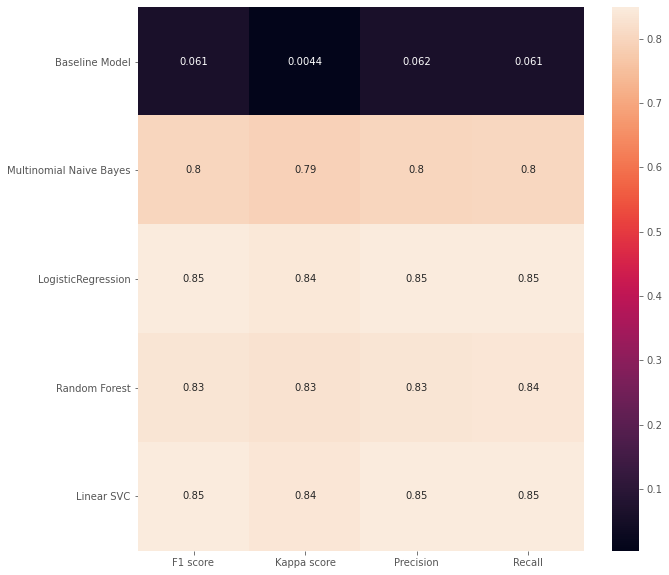

In [40]:
plt.figure(figsize = (10,10))
sns.heatmap(add_test_score('Linear SVC', svm_best, X_test, y_test).T, annot = True);

In [41]:
# save model
# with open('../models/cuisine_prediction/svc.pkl', 'wb') as file:   
#    pickle.dump(svm_best, file)

## 7. Final Model Evaluation

- Based on the performance of the 4 machine learning algorithms, I will use the logistic regression model as the final model
- The logistic regression model outperformed the multinomial Naive Bayes and Random Forest models (and the Random Forest model has a significantly slower run time)
- The logistic regression model performed similarly to the linear SVC, however, as the logistic regression model is more explainable (through coefficient analysis) I will use this as the final model

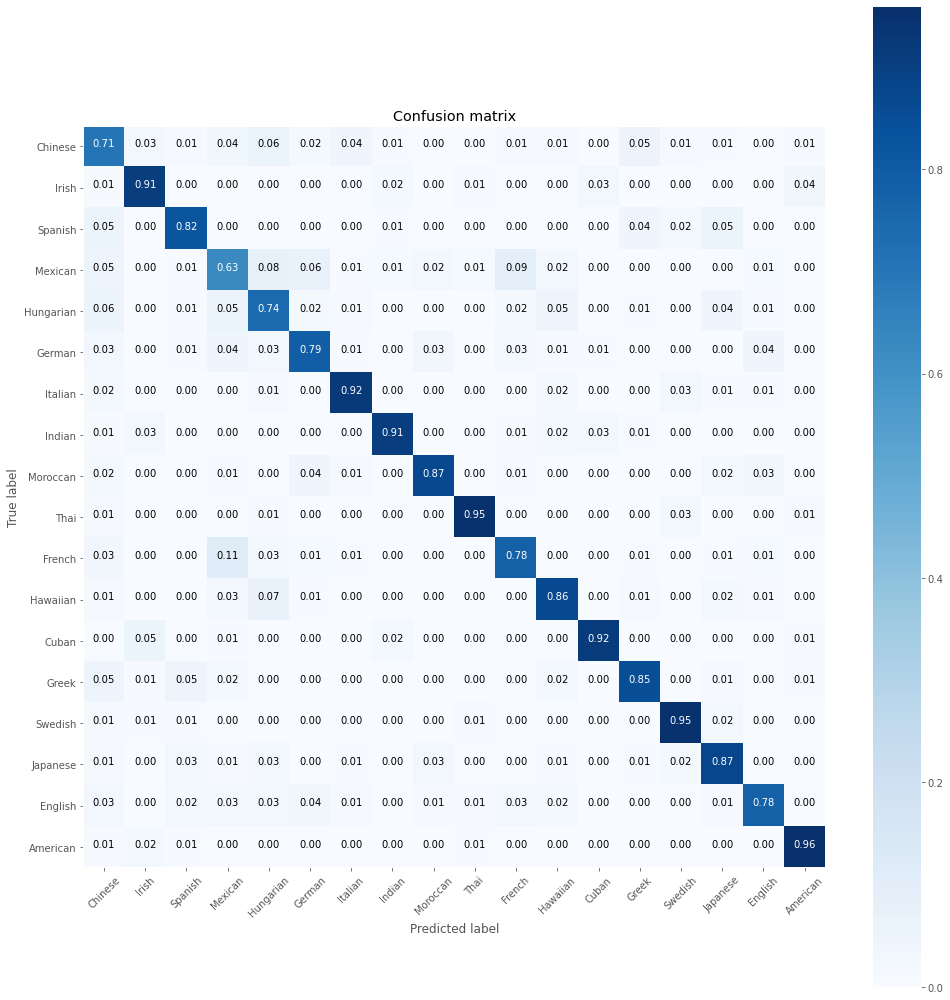

In [43]:
# Compute confusion matrix
y_pred = lr_best.predict(X_test)
cnf_matrix = confusion_matrix(y_test.values, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(14,14))
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion matrix', normalize = True)

- Mexican cuisine had the lowest accuracy, where it seems many recipes were misclassified as Hungarian or French
- All other recipes seem to have an accuracy above 70%
- I will use a Sankey diagram below to better represent the confusions of the classifier

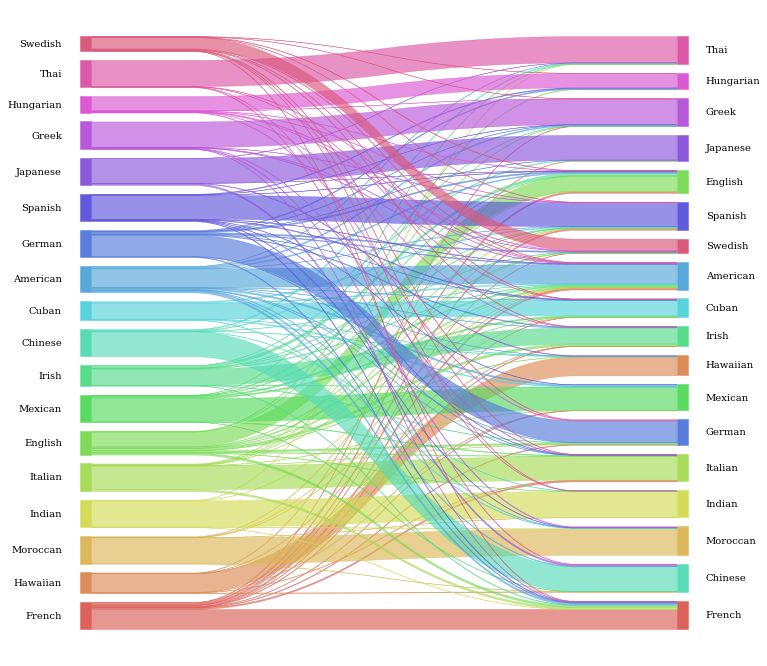

In [45]:
sankey_data = pd.DataFrame([y_test.values,y_pred], index = ['true', 'predicted']).T


sankey.sankey(sankey_data['true'], sankey_data['predicted'], aspect=30,
    fontsize=10)
plt.gcf().set_size_inches(12,12);


* On both sides of the sankey diagram, all the cuisines are listed. The cuisines on the left are the true cuisine labels, and on the right are the predicted cuisine labels. The size of the bar is proportional to how many recipes were classified to the given predicted cuisine. 
* From the sankey diagram, it is easy to see that a majority of the cuisines were predicted correctly
- Lets look at a sankey diagram of only recipes that were misclassified for better analysis

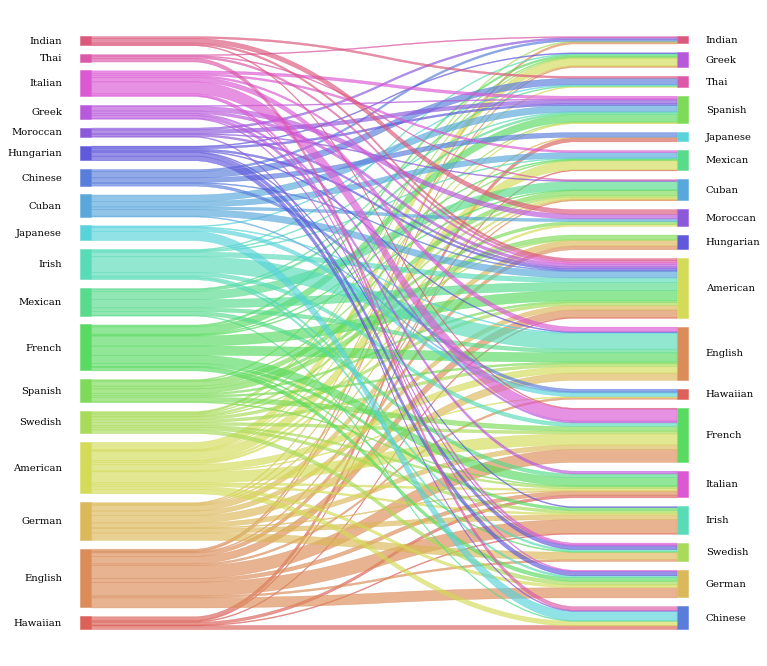

In [47]:
sankey_filtered = sankey_data[sankey_data['true']!=sankey_data['predicted']]

sankey.sankey(sankey_filtered['true'], sankey_filtered['predicted'], aspect=30,
    fontsize=10)
plt.gcf().set_size_inches(12,12);

- As a first observation, it is clear to see that most of the cuisines confused are geograhically close
- For example, Mexican cuisine (which had the highest misclassification rate) is mostly confused with American and Cuban cuisine, which makes sense given its geographic location
- Interestingly, almost all the Irish recipes that are misclassified are confused with English dishes, but English dishes are confused with Irish, French, German, and American dishes
- The sankey chart gives an interesting view of how cuisines influence each other

In [51]:
# Display a sample of most distinctive ingredients
df_dist_ing = None
cuisines = list(set(data.cuisine))
for i in range(len(cuisines)):
    top_features = [tvec.get_feature_names()[ing_id] for ing_id in np.argsort(-lr_best.coef_[i])[:20]]
    dist_ing_df_i = pd.DataFrame(data= {'Cuisine': data.cuisine.astype('category').cat.categories[i],
                                     'Most distinctive ingredients': top_features[:5]})
    display(dist_ing_df_i)

,Cuisine,Most distinctive ingredients
0,American,buttermilk
1,American,celery
2,American,pecan
3,American,tenderloin
4,American,bourbon


,Cuisine,Most distinctive ingredients
0,Chinese,soy
1,Chinese,cornstarch
2,Chinese,sesame
3,Chinese,ginger
4,Chinese,hoisin


,Cuisine,Most distinctive ingredients
0,Cuban,lime
1,Cuban,cumin
2,Cuban,plantain
3,Cuban,bean
4,Cuban,pickle


,Cuisine,Most distinctive ingredients
0,English,stilton
1,English,beef
2,English,pudding
3,English,flour
4,English,puff


,Cuisine,Most distinctive ingredients
0,French,thyme
1,French,tarragon
2,French,cognac
3,French,swiss
4,French,butter


,Cuisine,Most distinctive ingredients
0,German,sauerkraut
1,German,bratwurst
2,German,caraway
3,German,gingersnap
4,German,cabbage


,Cuisine,Most distinctive ingredients
0,Greek,feta
1,Greek,oregano
2,Greek,yogurt
3,Greek,lemon
4,Greek,cucumber


,Cuisine,Most distinctive ingredients
0,Hawaiian,pineapple
1,Hawaiian,soy
2,Hawaiian,sauce
3,Hawaiian,sesame
4,Hawaiian,coconut


,Cuisine,Most distinctive ingredients
0,Hungarian,paprika
1,Hungarian,sour
2,Hungarian,noodle
3,Hungarian,caraway
4,Hungarian,tomato


,Cuisine,Most distinctive ingredients
0,Indian,curry
1,Indian,masala
2,Indian,turmeric
3,Indian,ginger
4,Indian,yogurt


,Cuisine,Most distinctive ingredients
0,Irish,potato
1,Irish,guinnes
2,Irish,cabbage
3,Irish,beer
4,Irish,lamb


,Cuisine,Most distinctive ingredients
0,Italian,parmesan
1,Italian,pasta
2,Italian,spaghetti
3,Italian,cheese
4,Italian,basil


,Cuisine,Most distinctive ingredients
0,Japanese,mirin
1,Japanese,sake
2,Japanese,miso
3,Japanese,soy
4,Japanese,panko


,Cuisine,Most distinctive ingredients
0,Mexican,tortilla
1,Mexican,salsa
2,Mexican,lime
3,Mexican,taco
4,Mexican,cheese


,Cuisine,Most distinctive ingredients
0,Moroccan,cinnamon
1,Moroccan,cumin
2,Moroccan,couscou
3,Moroccan,harissa
4,Moroccan,chickpea


,Cuisine,Most distinctive ingredients
0,Spanish,chorizo
1,Spanish,paprika
2,Spanish,saffron
3,Spanish,olive
4,Spanish,sherry


,Cuisine,Most distinctive ingredients
0,Swedish,cream
1,Swedish,allspice
2,Swedish,meatball
3,Swedish,beef
4,Swedish,nutmeg


,Cuisine,Most distinctive ingredients
0,Thai,fish
1,Thai,peanut
2,Thai,curry
3,Thai,coconut
4,Thai,lime


- Using the logisitic regression model coefficients, I can see which ingredients are most distinctive for each cuisine. Distinctive ingredients are ingredients which best help the logistic regression model differentiate a particular cuisine from all the other cuisines